In [ ]:
%pip install efficientnet_pytorch
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Initializing

In [ ]:
import torch
import torchvision
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
import torchaudio
from torchvision import transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import time
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

In [ ]:
#model:

model_b = 2 #   b0 ----> b3

#hyperparams:
batch_size = 80
learning_rate = 0.00002
num_epochs = 120
audio_sample_duration = 3
training_set = 2 #  1 - 100hours    2 - 360hours

#regularization parameters:
dropout = 0.1
wd=0.001


# Data Augmentation parameters:

DA_active = 0    # 0 = OFF     1 = ON
flip_p = 0.0
blur_p = 0.0
rot_p = 0.0
affine_p = 0.0


In [ ]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
else:
    print('CUDA is available! Training on GPU...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mount Google Drive
#drive.mount('/content/drive')

# Path to the root directory where LibriSpeech is stored
#librispeech_root = "/content/drive/My Drive/DL_proj/LibriSpeech/dev-clean/"

if training_set == 1:
    librispeech_train = r"H:\Roy\LibriSpeech\train-clean-100"
    print("training on 100 hours")
elif training_set == 2:
    librispeech_train = r"H:\Roy\LibriSpeech\train-clean-360"
    print("training on 360 hours")
else:
    print("Error selecting training set!")


# librispeech_test = r"H:\Roy\LibriSpeech\test-clean"


CUDA is available! Training on GPU...
training on 360 hours


# Defining Net and Dataset

In [ ]:
# Define the EfficientNet model based on model selected
class EfficientNetSpeakerID(nn.Module):
    def __init__(self, num_classes, dropout_rate=0):
        super(EfficientNetSpeakerID, self).__init__()
        if model_b == 0:
            self.effnet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
        elif model_b == 1:
            self.effnet = EfficientNet.from_pretrained('efficientnet-b1', num_classes=num_classes)
        elif model_b == 2:
            self.effnet = EfficientNet.from_pretrained('efficientnet-b2', num_classes=num_classes)
        elif model_b == 3:
            self.effnet = EfficientNet.from_pretrained('efficientnet-b3', num_classes=num_classes)
        else:
            print("ERROR selecting EfficientNet model!")
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.effnet(x)
        x = self.dropout(x)
        return x

class MelSpectrogramDataset(Dataset):
    def __init__(self, audio_files, speaker_ids, duration=3, transform=None):
        self.audio_files = audio_files
        self.speaker_ids = speaker_ids
        self.duration = duration
        self.transform = transform
        # Create a dictionary to map speaker IDs to unique integers
        self.speaker_to_label = {speaker_id: idx for idx, speaker_id in enumerate(set(speaker_ids))}

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path, speaker_id = self.audio_files[idx], self.speaker_ids[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Trim or pad audio to the desired duration
        if waveform.size(1) < self.duration * sample_rate:
            pad_width = self.duration * sample_rate - waveform.size(1)
            waveform = torch.nn.functional.pad(waveform, (0, pad_width))
        elif waveform.size(1) > self.duration * sample_rate:
            waveform = waveform[:, :self.duration * sample_rate]

        mel_sgram = librosa.feature.melspectrogram( # creating the spectrogram sample
            y=waveform.numpy().squeeze(),
            sr=sample_rate,
            n_fft=400,
            hop_length=160,
            # n_mels=260
            n_mels=128
        )
        mel_sgram_db = librosa.power_to_db(mel_sgram, ref=np.min) # converting to dB

        mel_sgram_rgb = np.stack([mel_sgram_db] * 3, axis=0) # stacking 3 times identically

        mel_sgram_tensor = torch.tensor(mel_sgram_rgb)

        if self.transform: #data augmentation
            mel_sgram_tensor = self.transform(mel_sgram_tensor)

        squeeze_factor = int(self.duration/3)

        # Downsample the tensor using average pooling to match the length of 3 seconds spectogram
        if squeeze_factor > 1:
            mel_sgram_tensor = F.avg_pool2d(mel_sgram_tensor, kernel_size=(1, squeeze_factor))

        # Map the speaker ID to its corresponding label
        label = self.speaker_to_label[speaker_id]

        return mel_sgram_tensor, label



Loading Dataset

In [ ]:
# data augmentation transform
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=flip_p),
    transforms.RandomApply([transforms.GaussianBlur(5)], p=blur_p),
    transforms.RandomApply([transforms.RandomRotation(5)], p=rot_p),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], p=affine_p),
])


# List all speaker directories
speaker_directories = [os.path.join(librispeech_train, d) for d in os.listdir(librispeech_train) if os.path.isdir(os.path.join(librispeech_train, d))]
# Create lists to hold speaker IDs and corresponding paths to their audio files
speaker_ids = []
audio_paths = []

# Iterate over each speaker directory
for speaker_dir in speaker_directories:
    # Extract speaker ID from directory name
    speaker_id = os.path.basename(speaker_dir)
    # List all audio files for the current speaker
    for root, _, files in os.walk(speaker_dir):
        for file in files:
            if file.endswith(".flac"):
                audio_files = os.path.join(root, file)
                # Append speaker ID and corresponding audio path to lists
                speaker_ids.append(speaker_id)
                audio_paths.append(audio_files)


# Check if the lists are populated correctly
if not audio_paths or not speaker_ids:
    raise ValueError("No audio files found or speaker IDs are missing.")

# Ensure the lengths of both lists are equal
if len(audio_paths) != len(speaker_ids):
    raise ValueError("Lengths of audio_paths and speaker_ids do not match.")


# Split the dataset into training, validation, and test sets (70% train, 10% validation, 20% test)
train_files, X_temp, train_speaker_ids, y_temp = train_test_split(audio_paths, speaker_ids, test_size=0.3, random_state=42, stratify=speaker_ids)
val_files, test_files, val_speaker_ids, test_speaker_ids = train_test_split(X_temp, y_temp, test_size=(2/3), random_state=42, stratify=y_temp)


print("number of files: (train and test)")
print(len(train_files))
print(len(test_files))
print(len(val_files))


# Create train and test datasets
if DA_active == 1:
    train_dataset = MelSpectrogramDataset(train_files, train_speaker_ids,audio_sample_duration, transform=data_transforms)
else:
    train_dataset = MelSpectrogramDataset(train_files, train_speaker_ids,audio_sample_duration) #without data augmentation

test_dataset = MelSpectrogramDataset(test_files, test_speaker_ids,audio_sample_duration)
val_dataset = MelSpectrogramDataset(val_files, val_speaker_ids,audio_sample_duration)

print("number of speakers:(train and test)")
print(len(set(train_dataset.speaker_ids)))
print(len(set(test_dataset.speaker_ids)))
print(len(set(val_dataset.speaker_ids)))

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


100%|██████████| 921/921 [00:01<00:00, 510.16it/s]


number of recordings:(total train + test)
104014
number of files: (train and test)
72809
20804
10401
number of speakers:(train and test)
921
921
921


Plotting sample spectrograms

Train Dataset:
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])


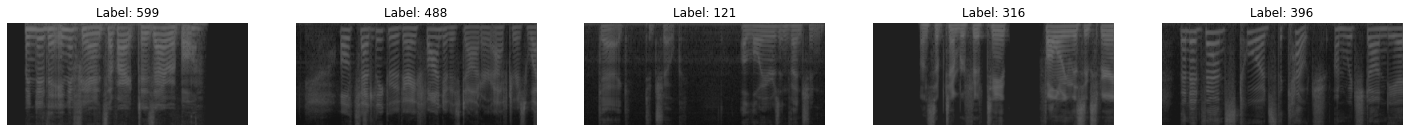


Test Dataset:
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])
Image Type: <class 'torch.Tensor'> Image Shape: torch.Size([3, 128, 301])


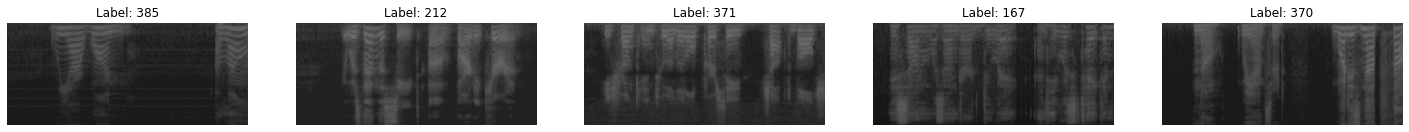

In [ ]:
# Function to plot images
def plot_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(25, 5))

    for i in range(num_images):
        index = np.random.randint(len(dataset))
        image, label = dataset[index]

        # Normalize image
        image = image / 255.0  # Assuming image values are in the range [0, 255]

        # Print output type and shape
        print("Image Type:", type(image), "Image Shape:", image.shape)

        # Plot image
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].set_title(f"Label: {label}")

        # Remove axis
        axes[i].axis('off')

    plt.show()

# Plot images from train dataset
print("Train Dataset:")
plot_images(train_dataset)

# Plot images from test dataset
print("\nTest Dataset:")
plot_images(test_dataset)


# Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
num_classes = len(set(train_speaker_ids))
print("number of classes for the model:")
print(num_classes)
model = EfficientNetSpeakerID(num_classes=num_classes, dropout_rate=dropout)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)

# Move model to GPU if available
model = model.to(device)

# Define the directory where you want to save the model weights
save_dir = r'H:\Roy\saved_weights'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Training function
def train(model, train_loader, criterion, optimizer, num_epochs=30):
    best_acc = 0.0
    best_epoch = 0
    best_weights = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        train_acc_list.append(train_acc)
        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.2f}%")

        if (epoch + 1) % 1 == 0:
            print("evaluating model:")
            val_acc = evaluate(model, val_loader)
            val_acc_list.append(val_acc)
            # Save the best model weights
            if val_acc > best_acc:
                best_acc = val_acc
                best_epoch = epoch + 1
                best_weights = model.state_dict()
                torch.save(best_weights, os.path.join(save_dir, 'speaker_recognition_model_b2.pth'))
                print("saved to:")
                print(os.path.join(save_dir, 'speaker_recognition_model_b2.pth'))



        print(f"Best Accuracy: {best_acc:.2f}% at Epoch {best_epoch}")
    return best_weights


# Evaluate function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluation', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return test_acc

#train on saved weights:
#model.load_state_dict(torch.load(os.path.join(save_dir, 'speaker_recognition_model_b0.pth')))
train_acc_list = []
val_acc_list = []
# Train the model
best_weights = train(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
# Load the best model weights
model.load_state_dict(best_weights)

# Evaluate the model
evaluate(model, test_loader)



number of classes for the model:
921


Epoch 1/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Loaded pretrained weights for efficientnet-b2


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 6.6842 | Train Acc: 1.02%
evaluating model:


Epoch 2/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 3.73%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 3.73% at Epoch 1


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 5.7918 | Train Acc: 7.59%
evaluating model:


Epoch 3/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 14.84%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 14.84% at Epoch 2


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 4.6591 | Train Acc: 21.86%
evaluating model:


Epoch 4/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 31.27%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 31.27% at Epoch 3


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 3.7452 | Train Acc: 39.61%
evaluating model:


Epoch 5/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 44.46%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 44.46% at Epoch 4


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 3.0300 | Train Acc: 53.73%
evaluating model:


Epoch 6/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 54.21%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 54.21% at Epoch 5


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 2.4491 | Train Acc: 64.67%
evaluating model:


Epoch 7/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 60.72%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 60.72% at Epoch 6


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 2.0239 | Train Acc: 72.03%
evaluating model:


Epoch 8/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 65.21%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 65.21% at Epoch 7


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 1.6918 | Train Acc: 77.41%
evaluating model:


Epoch 9/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 68.42%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 68.42% at Epoch 8


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 1.4526 | Train Acc: 81.18%
evaluating model:


Epoch 10/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 70.70%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 70.70% at Epoch 9


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 1.2837 | Train Acc: 83.54%
evaluating model:


Epoch 11/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 72.12%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 72.12% at Epoch 10


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 1.1458 | Train Acc: 85.23%
evaluating model:


Epoch 12/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 73.16%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 73.16% at Epoch 11


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 1.0523 | Train Acc: 86.36%
evaluating model:


Epoch 13/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 73.69%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 73.69% at Epoch 12


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.9709 | Train Acc: 87.32%
evaluating model:


Epoch 14/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 73.91%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 73.91% at Epoch 13


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.8887 | Train Acc: 88.20%
evaluating model:


Epoch 15/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 74.41%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 74.41% at Epoch 14


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.8572 | Train Acc: 88.47%
evaluating model:


Epoch 16/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 74.73%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 74.73% at Epoch 15


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.8167 | Train Acc: 88.86%
evaluating model:


Epoch 17/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 74.91%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 74.91% at Epoch 16


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.7873 | Train Acc: 89.11%
evaluating model:


Epoch 18/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.04%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 75.04% at Epoch 17


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.7741 | Train Acc: 89.09%
evaluating model:


Epoch 19/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.05%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 75.05% at Epoch 18


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.7569 | Train Acc: 89.21%
evaluating model:


Epoch 20/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.22%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 75.22% at Epoch 19


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.7367 | Train Acc: 89.40%
evaluating model:


Epoch 21/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.30%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 75.30% at Epoch 20


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.7261 | Train Acc: 89.46%
evaluating model:


Epoch 22/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.28%
Best Accuracy: 75.30% at Epoch 20


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.7121 | Train Acc: 89.59%
evaluating model:


Epoch 23/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.33%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 75.33% at Epoch 22


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.7072 | Train Acc: 89.62%
evaluating model:


Epoch 24/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.30%
Best Accuracy: 75.33% at Epoch 22


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.7005 | Train Acc: 89.68%
evaluating model:


Epoch 25/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.45%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 75.45% at Epoch 24


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.6971 | Train Acc: 89.66%
evaluating model:


Epoch 26/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.44%
Best Accuracy: 75.45% at Epoch 24


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.6923 | Train Acc: 89.70%
evaluating model:


Epoch 27/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.53%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 75.53% at Epoch 26


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.6750 | Train Acc: 89.96%
evaluating model:


Epoch 28/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.52%
Best Accuracy: 75.53% at Epoch 26


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.6858 | Train Acc: 89.79%
evaluating model:


Epoch 29/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.60%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 75.60% at Epoch 28


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.6830 | Train Acc: 89.80%
evaluating model:


Epoch 30/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.66%
saved to:
H:\Roy\saved_weights\speaker_recognition_model_b2.pth
Best Accuracy: 75.66% at Epoch 29


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.6902 | Train Acc: 89.67%
evaluating model:


Epoch 31/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.60%
Best Accuracy: 75.66% at Epoch 29


Evaluation:   0%|          | 0/131 [00:00<?, ?batch/s]

Train Loss: 0.6726 | Train Acc: 89.99%
evaluating model:


Epoch 32/120:   0%|          | 0/911 [00:00<?, ?batch/s]

Test Accuracy: 75.65%
Best Accuracy: 75.66% at Epoch 29


Epoch 32/120:  34%|███▎      | 306/911 [06:31<12:53,  1.28s/batch]


KeyboardInterrupt: 

# Testing Saved Weights

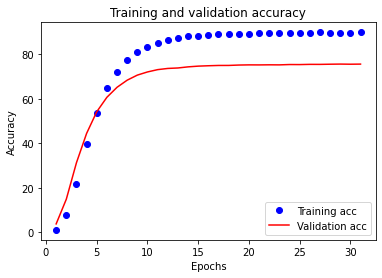

Evaluation:   0%|          | 0/261 [00:00<?, ?batch/s]

model:2
training_set 2, batch_size 80, learning_rate 2e-05, num_epochs 120, 
audio_sample_duration 3, dropout 0.1, wd 0.001, 
DA_active 0, flip_p 0.0, blur_p 0.0, rot_p 0.0, affine_p 0.0


Evaluation: 100%|██████████| 261/261 [16:29<00:00,  3.79s/batch]

Test Accuracy: 70.57%


70.56815996923669

In [ ]:
# Load the saved weights
model.load_state_dict(torch.load(os.path.join(save_dir, f'speaker_recognition_model_b{model_b}.pth')))

# plotting the training convergence:
try:
    train_acc_list # checking if training block was run or not

    x = range(1, len(train_acc_list) + 1)
    plt.plot(x, train_acc_list, 'bo', label='Training acc')
    plt.plot(x, val_acc_list, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    #print the hyperparams:
    print(f"model:{model_b}")
    # print("model:2")
    print(f"training_set {training_set}, batch_size {batch_size}, learning_rate {learning_rate}, num_epochs {num_epochs}, \naudio_sample_duration {audio_sample_duration}, dropout {dropout}, wd {wd}, \nDA_active {DA_active}, flip_p {flip_p}, blur_p {blur_p}, rot_p {rot_p}, affine_p {affine_p}")
except NameError:
    print("train_acc_list is not defined. no training to plot. skipping to evaluation.")

# Evaluate the model
evaluate(model, test_loader)